### 1. Import Required Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Any
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import SGDClassifier

# Suppress warnings for cleaner output presentation
import warnings
warnings.filterwarnings('ignore')

# To import MNIST dataset
from sklearn.datasets import fetch_openml

### 2. Define Functions

In [2]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [24]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name=None, labels=None, figsize=(6, 4), normalize=False):
    """
    Plot a confusion matrix using Seaborn.
    
    Parameters:
        y_true : array-like, true labels
        y_pred : array-like, predicted labels
        model_name : str, optional, name of the model for the title
        labels : list, optional, class labels
        figsize : tuple, optional, size of the figure
        normalize : bool, optional, normalize counts to percentages
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                cmap="Blues", cbar=False,
                xticklabels=labels if labels is not None else True,
                yticklabels=labels if labels is not None else True)
    
    title = "Confusion Matrix"
    if model_name:
        title += f" - {model_name}"
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

### 3. Fetch and load Data, Exploratory Data Analysis and Split Into Training and Test Sets!

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist["data"],mnist["target"]

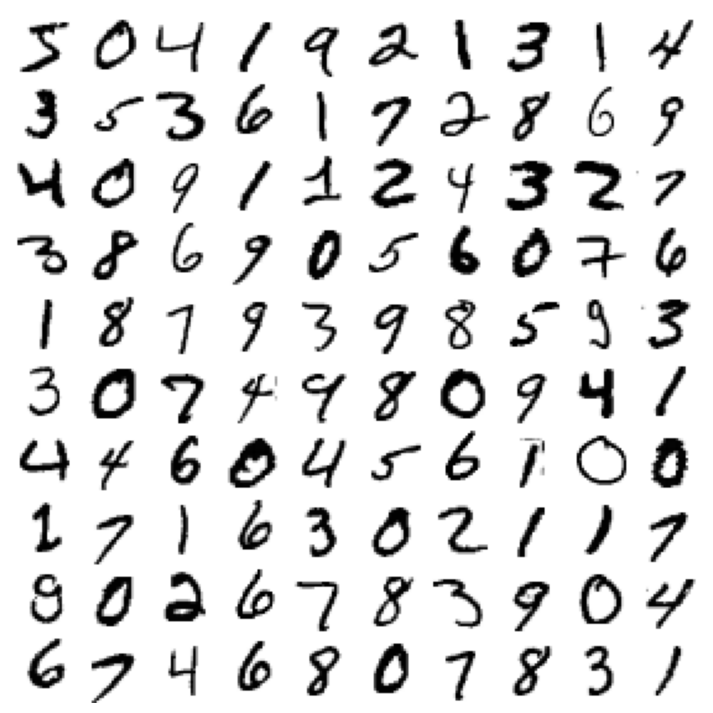

In [6]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [7]:
X.shape

(70000, 784)

In [8]:
28*28

784

In [9]:
some_digit = X[7]

In [10]:
some_digit

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  38,  43, 105, 255, 253,
       253, 253, 253, 253, 174,   6,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  43, 139, 224, 22

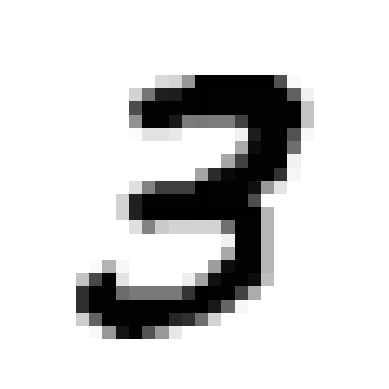

In [11]:
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [12]:
y[7]

'3'

In [13]:
type(y[7])

str

In [14]:
y = y.astype(np.uint8)

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 4. Simpifying the problem and training a Binary Classifier!

In [16]:
y_train_3 = (y_train == 3)

In [17]:
models = [
    ('MLP', MLPClassifier()),
    #('RFC', RandomForestClassifier()),
    #('SVC', SVC()),
    #('AdaB', AdaBoostClassifier()),
    #('GBC', GradientBoostingClassifier()),
    #('DTC', DecisionTreeClassifier()),
    #('XGB', XGBClassifier()),
    #('LR', LogisticRegression(max_iter=500)),
    ('SGD', SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)),
]

In [18]:
# Cross-validation setup
num_folds = 3
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
error_metrics = ['accuracy', 'f1']  # removed roc_auc

trained_models = {}
cv_results_summary = []

for name, model in models:
    print(f"Training model: {name}...")
    
    # Fit model on the entire training set
    model.fit(X_train, y_train_3)
    
    # Store trained model
    trained_models[name] = model
    
    # Cross-validation scores
    metric_scores = {}
    for scoring in error_metrics:
        scores = cross_val_score(model, X_train, y_train_3, cv=cv, scoring=scoring)
        metric_scores[scoring] = (scores.mean(), scores.std())
        print(f"{name} - {scoring}: Mean={scores.mean():.4f}, Std={scores.std():.4f}")
    
    cv_results_summary.append((name, metric_scores))
    print("-"*50)

Training model: MLP...
MLP - accuracy: Mean=0.9930, Std=0.0011
MLP - f1: Mean=0.9571, Std=0.0061
--------------------------------------------------
Training model: SGD...
SGD - accuracy: Mean=0.9614, Std=0.0078
SGD - f1: Mean=0.8151, Std=0.0220
--------------------------------------------------


### 5. Creating an All False Classifier and Proving that Accuracy is Misleading

In [19]:
from sklearn.base import BaseEstimator
class always_false(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_3= always_false()
cross_val_score(never_3, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.8962 , 0.89975, 0.8975 ])

In [21]:
# Convert to pandas Series if not already
y_series = pd.Series(y_train)

# Count frequency of each digit
counts = y_series.value_counts().sort_index()
labels = counts.index
frequencies = counts.values

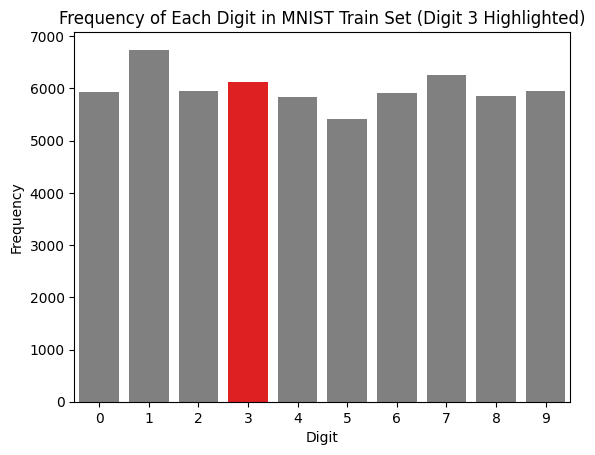

Frequency of digit 3: 6131
Total number of labels: 60000


In [22]:
# Highlight the digit '3'
colors = ['red' if label == 3 else 'grey' for label in labels]

# Plot
sns.barplot(x=labels, y=frequencies, palette=colors)
plt.title('Frequency of Each Digit in MNIST Train Set (Digit 3 Highlighted)')
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.show()

# Print frequency of '3' and total
print(f"Frequency of digit 3: {counts[3]}")
print(f"Total number of labels: {frequencies.sum()}")

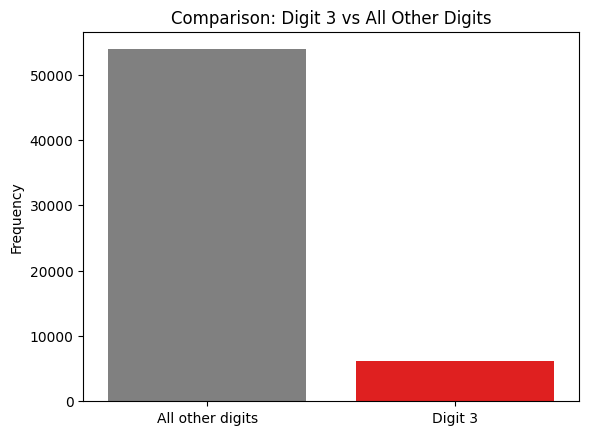

Frequency of all other digits: 53869
Frequency of digit 3: 6131
Total number of labels: 60000


In [23]:
# Count total frequency of '3' and all other digits
count_3 = (y_series == 3).sum()
count_others = (y_series != 3).sum()

# Create data for plotting
labels = ['All other digits', 'Digit 3']
frequencies = [count_others, count_3]

# Plot
sns.barplot(x=labels, y=frequencies, palette=['grey', 'red'])
plt.title('Comparison: Digit 3 vs All Other Digits')
plt.ylabel('Frequency')
plt.show()

# Print counts
print(f"Frequency of all other digits: {count_others}")
print(f"Frequency of digit 3: {count_3}")
print(f"Total number of labels: {count_others + count_3}")

### 6. Confusion Matrix: Precision, Recall & F1

Evaluating model: MLP
MLP - Accuracy: 0.9925, Precision: 0.9722, Recall: 0.9537


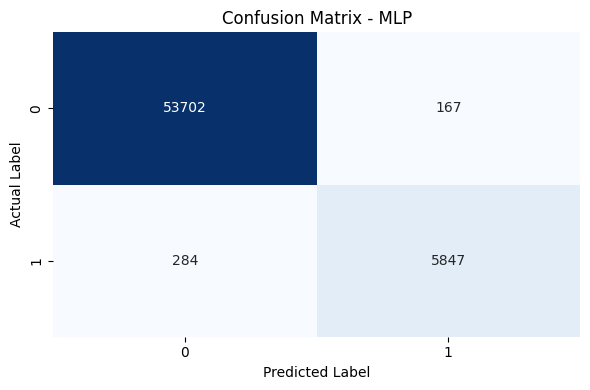

--------------------------------------------------
Evaluating model: SGD
SGD - Accuracy: 0.9614, Precision: 0.8031, Recall: 0.8238


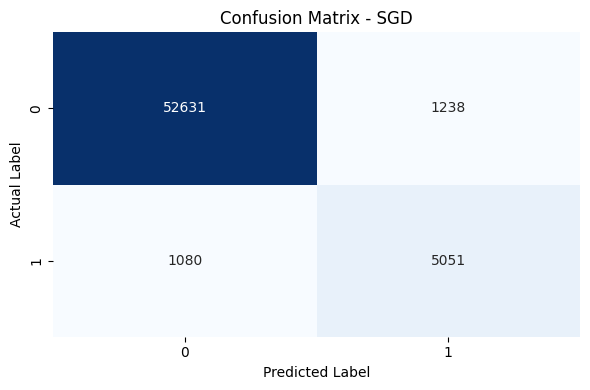

--------------------------------------------------


In [25]:
for name, model in trained_models.items():
    print(f"Evaluating model: {name}")
    
    # Generate cross-validated predictions
    y_train_pred = cross_val_predict(model, X_train, y_train_3, cv=cv)
    
    # Compute metrics
    acc = accuracy_score(y_train_3, y_train_pred)
    precision = precision_score(y_train_3, y_train_pred)
    recall = recall_score(y_train_3, y_train_pred)
    
    # Print metrics
    print(f"{name} - Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_train_3, y_train_pred, name)
    print("-"*50)